# Notebooks para estudar os dados do Daylio


In [37]:
# Dependências
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import scipy.optimize as opt
from pandas.tools.plotting import table
import sklearn.linear_model as lm
import statsmodels.api as sm
import scipy.fftpack as fft

In [38]:
# Pontuar as opções de humor contidos nos dados do Daylio
mood_score = {"awful": 0, "melancholic": 0, "aaa": 0,
              "bad": 1, "shitty": 1, "grr": 1,
              "aff":2, "zzz": 2, "meh": 2,
              "good": 3, "satisfied": 3, "gogo": 3,
              "rad": 4, "wonderful": 4, "hihi": 4}

In [39]:
# Preparar dados do humor
raw_mood_data = pd.read_csv("daylio_export.csv", parse_dates=[[0, 1, 2, 3]], index_col="year_date_weekday_time")
raw_mood_data = raw_mood_data.replace({"mood": mood_score}).copy()
raw_mood_data = raw_mood_data.replace(np.nan, "")
mood_data = raw_mood_data.copy()
mood_data.mood *= 100
mood_data.mood /= 4 # Normalizar para um domínio entre [0, 100]

In [40]:
# Separar as atividades contidas em cada linha de dados

activities_string = " | ".join(mood_data.activities.values)
activities_string = activities_string.split(" | ")
unique_activities = np.unique(activities_string)
unique_activities = unique_activities[unique_activities != ""]
mood_data.activities = mood_data.activities.str.split(" \| ")

In [41]:
# Gerar colunas novas com as atividades e já preparar uma lista com variaveis de interesse

mood_ranking = []

for activity in unique_activities:
    contains_activity = mood_data.activities.apply(lambda x: activity in x)
    mood_data[activity] = contains_activity
    
    ind = mood_data[activity] == True
    score = np.mean(mood_data[ind].mood)
    count = len(mood_data[ind])
    std = np.std(mood_data[ind].mood)
    mood_ranking.append({"activity": activity, "score": "{:.1f}".format(score), "count": count})

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: 'pandas.tools.plotting.table' is deprecated, import 'pandas.plotting.table' instead.
  """


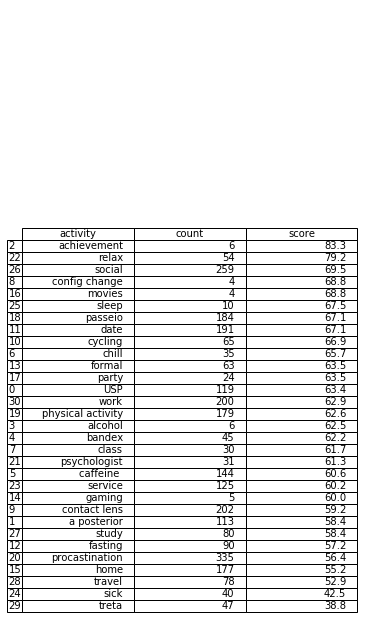

In [42]:
mood_ranking = pd.DataFrame(mood_ranking).sort_values("score", ascending=False)
ax = plt.subplot(111, frame_on=False) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis
table(ax, mood_ranking)  # where df is your data frame
plt.show()

In [24]:
#samp = "15d"
daily_mood = mood_data.resample("7d").mean().mood
#daily_mood_std = mood_data.resample(samp).std().mood

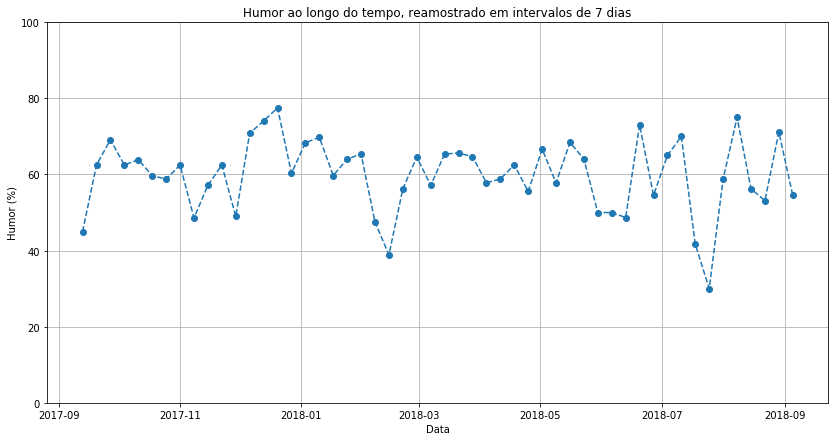

In [25]:
plt.figure(figsize=(14, 7))
plt.grid()
plt.plot(daily_mood, "--o")
#plt.plot(mood_data[mood_data.sick == True].mood, 'o')
plt.ylim((0, 100))
plt.title("Humor ao longo do tempo, reamostrado em intervalos de 7 dias")
plt.ylabel("Humor (%)")
plt.xlabel("Data")
plt.show()

In [26]:
unique_activities_2 = []
for activity in unique_activities:
    if mood_data[activity].sum() > 19:
        unique_activities_2.append(activity)

In [27]:
N_samples = len(mood_data)
N_features = len(unique_activities_2)
features = []

X = np.zeros((N_samples, N_features))
Y = np.array(mood_data.mood.values)
for i in range(N_features):
    feature = unique_activities_2[i]
    features.append(feature)
    X[:, i] = mood_data[feature].astype(int)

X = sm.add_constant(X)
est = sm.OLS(Y, X).fit()
a = est.summary()

In [28]:
cov_mtr = est.cov_params()

In [29]:
diag = np.diag(np.diag(cov_mtr))

In [30]:
D = np.linalg.inv(np.sqrt(diag))

In [31]:
r = np.matmul(D, np.matmul(cov_mtr, D))
#r[r > 0.99] = np.nan

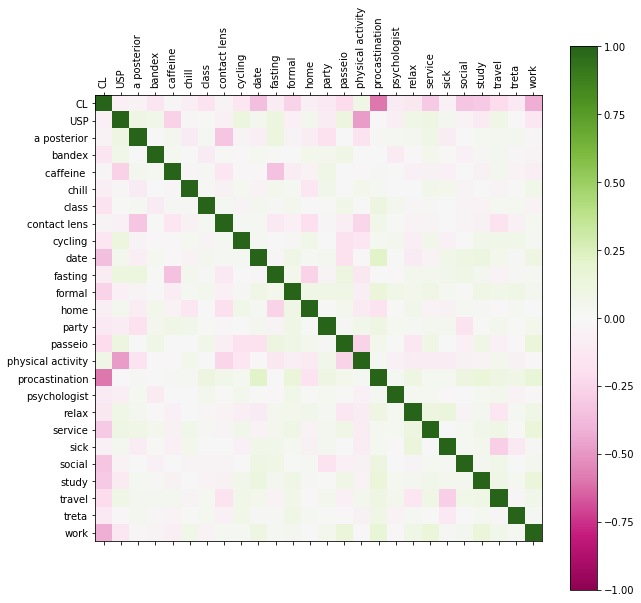

In [32]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
mtr = ax.matshow(r, vmin=-1, vmax=1, cmap="PiYG")
plt.colorbar(mtr)
ax.set_xticks(np.arange(r.shape[0]))
ax.set_xticklabels(["CL"] + unique_activities_2, rotation="vertical")
ax.set_yticks(np.arange(r.shape[0]))
ax.set_yticklabels(["CL"] + unique_activities_2, rotation="horizontal")
plt.show()

In [33]:
r.shape

(26, 26)

In [34]:
unique_activities_2[0]

'USP'

In [35]:
i = 0
for activity in unique_activities_2:
    a.tables[1][2:][i][0].data = activity
    i += 1

In [36]:
a

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.287
Model:                            OLS   Adj. R-squared:                  0.265
Method:                 Least Squares   F-statistic:                     13.16
Date:                Tue, 11 Sep 2018   Prob (F-statistic):           5.37e-45
Time:                        18:00:44   Log-Likelihood:                -3625.3
No. Observations:                 845   AIC:                             7303.
Df Residuals:                     819   BIC:                             7426.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                54.6561      1.563     34.970      0.000      51.588      57.724
USP                   4.4862      2.516      1.783      0.075      -0.452       9.425
a posterior          -3.7188      2.216     -1.678      0.094      -8.069       0.631
bandex                1.3998      2.858      0.490      0.624      -4.210       7.010
caffeine              0.6951      2.111      0.329      0.742      -3.448       4.838
chill                 7.2658      3.213      2.262      0.024       0.960      13.572
class                -1.8789      3.440     -0.546      0.585      -8.631       4.874
contact lens         -1.9296      2.103     -0.918      0.359      -6.057       2.198
cycling               1.3504      2.504      0.539      0.590      -3.565       6.266
date                  6.2536      1.639      3.817      0.000       3.037       9.470
fasting               2.1909      2.458      0.891      0.373      -2.633       7.015
formal                1.4404      2.517      0.572      0.567      -3.500       6.381
home                 -3.1146      1.855     -1.679      0.094      -6.756       0.526
party                -2.1334      3.944     -0.541      0.589      -9.876       5.609
passeio               5.9002      1.843      3.201      0.001       2.282       9.518
physical activity     0.1045      2.382      0.044      0.965      -4.571       4.781
procastination       -2.6059      1.429     -1.824      0.068      -5.410       0.198
psychologist          1.3684      3.374      0.406      0.685      -5.254       7.991
relax                15.3185      2.822      5.428      0.000       9.779      20.858
service               3.5191      1.824      1.929      0.054      -0.061       7.100
sick                 -9.5439      3.199     -2.983      0.003     -15.823      -3.265
social               12.1144      1.418      8.546      0.000       9.332      14.897
study                -1.1980      2.236     -0.536      0.592      -5.587       3.190
travel               -5.3342      2.415     -2.209      0.027     -10.074      -0.595
treta               -22.4359      2.796     -8.025      0.000     -27.924     -16.948
work                  5.1633      1.594      3.239      0.001       2.034       8.292
==============================================================================
Omnibus:                       26.255   Durbin-Watson:                   1.457
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               27.926
Skew:                          -0.425   Prob(JB):                     8.63e-07
Kurtosis:                       3.264   Cond. No.                         8.92
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [25]:
with open("daylio-variable-influence.html", "w") as fid:
    fid.write(a.as_html())

In [26]:
X = mood_data.drop(["activities", "note", "mood"], axis=1).values
y = mood_data.mood.values > 75

In [27]:
from sklearn.svm import SVC
model = SVC(kernel='linear', C=1E10, max_iter=100)
model.fit(X, y)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVC(C=10000000000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=100, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [28]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

ValueError: X.shape[1] = 2 should be equal to 31, the number of features at training time

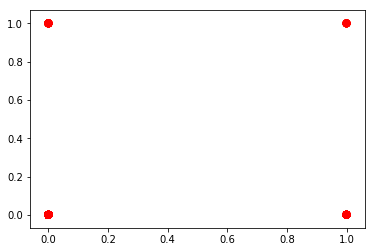

In [29]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model);

## Google fit

In [30]:
fit_data = pd.read_csv("google-fit.csv",index_col="Date", parse_dates=["Date"])

In [31]:
fit_data.columns

Index(['Calories (kcal)', 'Distance (m)', 'Average heart rate (bpm)',
       'Max heart rate (bpm)', 'Min heart rate (bpm)', 'Low latitude (deg)',
       'Low longitude (deg)', 'High latitude (deg)', 'High longitude (deg)',
       'Average speed (m/s)', 'Max speed (m/s)', 'Min speed (m/s)',
       'Step count', 'Average weight (kg)', 'Max weight (kg)',
       'Min weight (kg)', 'Biking duration (ms)', 'Inactive duration (ms)',
       'Unknown duration (ms)', 'Walking duration (ms)',
       'Running duration (ms)', 'Sleep duration (ms)',
       'Light sleeping duration (ms)', 'Deep sleeping duration (ms)',
       'REM sleeping duration (ms)', 'Awake mid-sleeping duration (ms)'],
      dtype='object')

In [32]:
bike_data = fit_data["Distance (m)"].copy() / 1000
#bike_data = fit_data["Biking duration (ms)"].copy() / (1000 * 60 * 60)

In [33]:
bike_data = bike_data[~pd.isnull(bike_data)]

In [34]:
bike_data2 = bike_data[bike_data.index >= "2016-03"]
bike_data2 = bike_data2.resample("7d").sum()

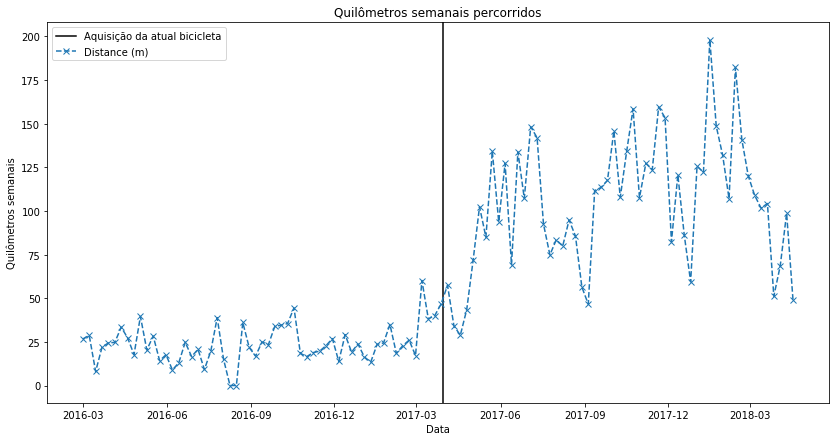

In [35]:
plt.figure(figsize=(14, 7))
plt.axvline(pd.to_datetime("2017-03-30"), color='k', label="Aquisição da atual bicicleta")
plt.title("Quilômetros semanais percorridos")
plt.xlabel("Data")
plt.ylabel("Quilômetros semanais")
plt.plot(bike_data2, '--x')

plt.legend()
plt.show()

In [36]:
freq = "1d"
min_date = "2017-06"
max_date = "2018-06"

inds = True
inds &= bike_data.index > min_date
inds &= bike_data.index < max_date
bike_data2 = bike_data[inds]

inds = True
inds &= mood_data.index > min_date
inds &= mood_data.index < max_date
mood_data2 = mood_data[inds]

daily_mood = mood_data2.resample(freq).mean().mood
daily_bike = bike_data2.resample(freq).mean()
merged_data = pd.DataFrame([daily_mood, daily_bike]).T
merged_data2 = merged_data.resample(freq).mean()

inds = True
inds &= ~pd.isnull(merged_data2.iloc[:, 0])
inds &= ~pd.isnull(merged_data2.iloc[:, 1])
merged_data3 = merged_data2[inds].copy()

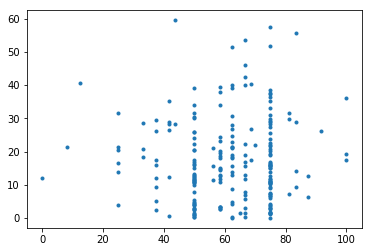

In [37]:
plt.plot(merged_data3.iloc[:, 0], merged_data3.iloc[:, 1], '.')
plt.show()

In [38]:
st.linregress(merged_data3.iloc[:, 0], merged_data3.iloc[:, 1])

LinregressResult(slope=0.029460394276700077, intercept=15.56552582048117, rvalue=0.03728206153900788, pvalue=0.5849167793674008, stderr=0.05385392630043326)

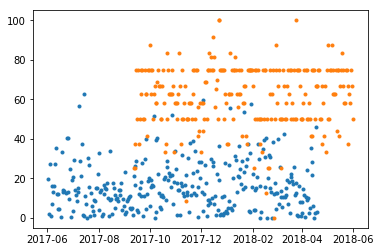

In [39]:
plt.plot(bike_data2, '.')
plt.plot(daily_mood, '.')
plt.show()

## Parte 2 - Sleep as Android

In [40]:
data1 = pd.read_csv("sleep-export.csv", usecols=np.arange(15))
inds = data1.iloc[:, 0] == "Id"
inds |= pd.isnull(data1.iloc[:, 0])
data1[~inds].to_csv("sleep-export_clean.csv", index=False)


In [49]:
data2 = pd.read_csv("sleep-export_clean.csv", parse_dates=["From", "To"])

inds = True
inds &= data2.Hours > 4
data2 = data2[inds]


data2.From = pd.to_datetime(data2.From, format="%d. %m. %Y %H:%M")
data2.To = pd.to_datetime(data2.To, format="%d. %m. %Y %H:%M")
hours = [pd.Timedelta(hours=h / 2) for h in data2.Hours]
data2["Mid"] = data2["From"] + hours

TypeError: unsupported operand type(s) for +: 'DatetimeIndex' and 'list'

In [ ]:
data2["Fro]

In [42]:
start = np.min(data2.Mid)
end = np.max(data2.Mid)
series = pd.date_range(start, end, freq="1d")

AttributeError: 'DataFrame' object has no attribute 'Mid'

In [43]:
inds = data2.Mid > "2017-01-01"
data3 = data2[inds]
data3 = data3.sort_values("Mid", ascending=False)

AttributeError: 'DataFrame' object has no attribute 'Mid'

In [44]:
z = data3.Mid.dt.hour + data3.Mid.dt.minute / 60

NameError: name 'data3' is not defined

In [45]:
plt.plot(data3.Mid.dt.date, (z + 0) % 24, '.')
plt.axvline("2018-01-10", color="C1")
plt.axvline("2017-12-05", color="C1")
plt.axvline("2017-10-01")
plt.axvline("2017-04-01", color="C2")
plt.show()

NameError: name 'data3' is not defined

In [5]:
def metric(z):
    out = st.circmean(z, high=24, low=0)
    return out

def smetric(z):
    out = 1 * st.circstd(z, high=24, low=0)
    return out

In [6]:
col = data3.To
z = col.dt.hour + col.dt.minute / 60
n = 7
if n % 2 == 0:
    x = col.dt.date[int(n/2):int(-n/2)]
else:
    x = col.dt.date[int(n/2):int(-n/2 - 1)]
    
plt.style.use("seaborn-dark")
y = z.rolling(n).apply(metric)[n:]
yerr = z.rolling(n).apply(smetric)[n:]
y0 = (y - yerr)
y1 = (y + yerr)
plt.figure(figsize=(15, 7))
plt.plot(x, y, '.', label="")
plt.fill_between(x.values.astype("O"), y0, y1, alpha=0.3, label=r"Desvio padrão semanal")
plt.axvline("2018-01-10", color="C2", label="Férias")
plt.axvline("2017-12-05", color="C2")
plt.axvline("2017-07-15", color="C2")
plt.axvline("2017-08-01", color="C2")
plt.axvline("2017-10-01", color="C1", label="Mudança")
#plt.axvline("2017-04-01", color="C2")
plt.title("Média circular rolante semanal do horário de acordar")
plt.ylabel("Hora do dia")
plt.xlabel("Data")
n_max = 24
n_min = 0
plt.ylim((n_min, n_max))
plt.yticks(np.arange(n_min, n_max+1, 2))
plt.grid()
plt.legend()
plt.show()

NameError: name 'data3' is not defined

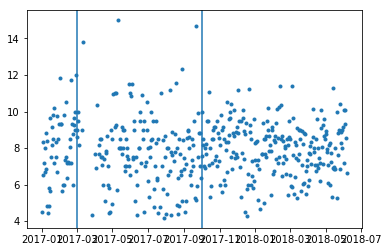

In [347]:
aaa = data3.groupby(data3.Mid.dt.date).sum()
plt.plot(aaa.Hours, '.')
plt.axvline("2017-10")
plt.axvline("2017-03")
plt.show()

In [277]:
data3.resample("1d", on="Mid").mean()

Id  Hours  Rating  Framerate  Snore     Noise  Cycles  \
Mid                                                                           
2016-10-10  1.476084e+12   6.94   2.000       10.0    0.0  0.165238     4.0   
2016-10-11  1.476172e+12   3.60   2.875       10.0    0.0  0.081706     1.5   
2016-10-12  1.476257e+12   7.32   4.000       10.0   -1.0  0.000000    -1.0   
2016-10-13  1.476349e+12   5.43   4.000       10.0  336.0  0.029830     2.5   
2016-10-14  1.476450e+12   3.51   1.875       10.0  167.5  0.007854     0.5   
2016-10-15  1.476521e+12   4.75   3.375       10.0   41.5  0.024142     1.5   
2016-10-16  1.476594e+12   9.41   2.250       10.0   84.0  0.045931     9.0   
2016-10-17  1.476687e+12   7.61   2.500       10.0  588.0  0.054076     6.0   
2016-10-18  1.476762e+12   7.80   2.500       10.0    0.0  0.042048     4.0   
2016-10-19  1.476858e+12   7.72   2.750       10.0    0.0  0.048433     3.0   
2016-10-20  1.476932e+12   8.47   2.750       10.0    0.0  0.082073     4.0   
2016-10-21           NaN    NaN     NaN        NaN    NaN       NaN     NaN   
2016-10-22           NaN    NaN     NaN        NaN    NaN       NaN     NaN   
2016-10-23           NaN    NaN     NaN        NaN    NaN       NaN     NaN   
2016-10-24           NaN    NaN     NaN        NaN    NaN       NaN     NaN   
2016-10-25           NaN    NaN     NaN        NaN    NaN       NaN     NaN   
2016-10-26           NaN    NaN     NaN        NaN    NaN       NaN     NaN   
2016-10-27           NaN    NaN     NaN        NaN    NaN       NaN     NaN   
2016-10-28           NaN    NaN     NaN        NaN    NaN       NaN     NaN   
2016-10-29           NaN    NaN     NaN        NaN    NaN       NaN     NaN   
2016-10-30           NaN    NaN     NaN        NaN    NaN       NaN     NaN   
2016-10-31           NaN    NaN     NaN        NaN    NaN       NaN     NaN   
2016-11-01           NaN    NaN     NaN        NaN    NaN       NaN     NaN   
2016-11-02           NaN    NaN     NaN        NaN    NaN       NaN     NaN   
2016-11-03           NaN    NaN     NaN        NaN    NaN       NaN     NaN   
2016-11-04           NaN    NaN     NaN        NaN    NaN       NaN     NaN   
2016-11-05           NaN    NaN     NaN        NaN    NaN       NaN     NaN   
2016-11-06           NaN    NaN     NaN        NaN    NaN       NaN     NaN   
2016-11-07  1.478501e+12   8.17   3.000       10.0    0.0  0.057416     4.0   
2016-11-08           NaN    NaN     NaN        NaN    NaN       NaN     NaN   
...                  ...    ...     ...        ...    ...       ...     ...   
2018-04-24  1.524539e+12   9.08   0.000    10005.0   -1.0 -1.000000    -1.0   
2018-04-25  1.524638e+12   8.08   0.000       10.0   -1.0  0.000000    -1.0   
2018-04-26  1.524719e+12   9.25   2.000    10005.0   -1.0 -1.000000    -1.0   
2018-04-27  1.524804e+12   7.12   2.000    10005.0   -1.0 -1.000000    -1.0   
2018-04-28  1.524890e+12   9.58   2.000       10.0   -1.0  0.000000    -1.0   
2018-04-29  1.524978e+12   8.67   4.000       10.0   -1.0  0.000000    -1.0   
2018-04-30  1.525066e+12   8.50   0.000    10005.0   -1.0 -1.000000    -1.0   
2018-05-01  1.525149e+12   8.92   0.000    10005.0   -1.0 -1.000000    -1.0   
2018-05-02  1.525237e+12   8.75   0.000       10.0   -1.0  0.000000    -1.0   
2018-05-03  1.525320e+12   7.92   4.000       10.0   -1.0  0.000000    -1.0   
2018-05-04  1.525410e+12   7.77   0.000    10005.0   -1.0 -1.000000    -1.0   
2018-05-05  1.525500e+12   7.07   4.000    10005.0   -1.0 -1.000000    -1.0   
2018-05-06  1.525587e+12   6.08   2.000    10005.0   -1.0 -1.000000    -1.0   
2018-05-07  1.525664e+12   8.17   3.750    10005.0   -1.0 -1.000000    -1.0   
2018-05-08  1.525750e+12   8.29   2.000    10005.0   -1.0 -1.000000    -1.0   
2018-05-09  1.525845e+12   6.00   0.000    10005.0   -1.0 -1.000000    -1.0   
2018-05-10  1.525925e+12   7.75   0.000    10005.0   -1.0 -1.000000    -1.0   
2018-05-11  1.526013e+12   7.24   3.750    10005.0   -1.0 -1.000000    -